In [1]:
%load_ext autoreload
%autoreload 2
from gratin.models.main_net import MainNet
from gratin.data.datamodule import DataModule
import pytorch_lightning as pl
from gratin.models.utils import get_predictions_of_dl
from gratin.training.callbacks import Plotter
import matplotlib.pyplot as plt
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from gratin.data.dataset import ExpTrajDataSet
from torch_geometric.loader import DataLoader
import os
from umap import ParametricUMAP
import tensorflow as tf
import numpy as np
import logging
import torch.cuda
import pandas as pd
from typing import Union, List
import warnings
from gratin.models.MMD_net import MMDNet

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

num_workers = 8
dim = 2
time_delta_range = (0.005,1.3)
length_range = (7,100)
log_diffusion_range = (-2.5,.5)
noise_range = (0.015,0.06)

graph_info = {
    "edges_per_point": 10,
    "clip_trajs": False,
    "scale_types": ["step_std","mean_time_step"],
    "log_features": True,
    "data_type": "no_features",  # no features because features are all computed by the model
    "edge_method": "geom_causal",
}

dl_params = {"batch_size": 264, "num_workers": num_workers}

ds_params = {
    "dim": dim,  # can be (1, 2 or 3)
    "RW_types": [
        "fBM",
        "LW",
        "OU",
        "sBM",
        "CTRW",
    ],  # Types of random walks used during training
    "time_delta_range": time_delta_range,
    "logdiffusion_range": log_diffusion_range,
    "length_range": length_range,
    "noise_range": noise_range,
    "N": int(1e5),
}

/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-21 16:42:46.747464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 16:42:46.883034: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-21 16:42:47.472133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shar

In [2]:
class Plot(Callback):
    def on_train_batch_end(self, 
        trainer: "pl.Trainer", 
        pl_module: "pl.LightningModule", 
        outputs, 
        batch, batch_idx: int) -> None:
        if batch_idx % 50 == 0:
            s = 3.
            h = outputs["h"].detach().cpu().numpy()
            h_norm = outputs["norm_h"].detach().cpu().numpy()
            alpha = batch.alpha[:,0].detach().cpu().numpy()
            log_diff = batch.log_diffusion[:,0].detach().cpu().numpy()
            L = batch.length[:,0].detach().cpu().numpy()
            m = batch.model[:,0].detach().cpu().numpy()

            pred_alpha = outputs["alpha"][:,0].detach().cpu().numpy()
            pred_m = outputs["model"].detach().cpu().numpy()
            pred_m = np.argmax(pred_m,axis=1)
            

            fig = plt.figure(figsize=(9,6))
            ax = fig.add_subplot(231)
            ax.scatter(h[:,0],h[:,1],c=alpha,cmap="coolwarm",vmin=0,vmax=2,s=s)
            ax = fig.add_subplot(232)
            for b in np.unique(m):
                ax.scatter(h[m == b,0],h[m == b,1],s=s,label=pl_module.hparams["RW_types"][b])
            plt.legend()
            ax = fig.add_subplot(233)
            ax.scatter(h[:,0],h[:,1],c=log_diff,s=s)
            ax = fig.add_subplot(234)
            ax.scatter(h_norm[:,0],h_norm[:,1],c=alpha,cmap="coolwarm",vmin=0,vmax=2,s=s)
            ax = fig.add_subplot(235)
            for b in np.unique(m):
                ax.scatter(h_norm[m == b,0],h_norm[m == b,1],s=s,label=pl_module.hparams["RW_types"][b])
            plt.legend()
            ax = fig.add_subplot(236)
            ax.scatter(h_norm[:,0],h_norm[:,1],c=log_diff,s=s)

            pl_module.logger.experiment.add_figure("Embedding", fig,global_step=trainer.global_step)

            fig = plt.figure(figsize=(9,3))
            ax = fig.add_subplot(131)
            ax.scatter(h[:,0],h[:,1],c=pred_alpha,cmap="coolwarm",vmin=0,vmax=2,s=s)
            ax = fig.add_subplot(132)
            for b in np.unique(m):
                ax.scatter(h[pred_m == b,0],h[pred_m == b,1],s=s,label=pl_module.hparams["RW_types"][b])
            plt.legend()
            ax = fig.add_subplot(133)
            ax.scatter(h[:,0],h[:,1],c=L,s=s)

            pl_module.logger.experiment.add_figure("Embedding_predictions", fig,global_step=trainer.global_step)

            fig = plt.figure(figsize=(6,3))
            ax = fig.add_subplot(121)
            ax.scatter(h[:,0],alpha)
            ax = fig.add_subplot(122)
            for b in np.unique(m):
                ax.hist(h[m == b,0],histtype="step")

            pl_module.logger.experiment.add_figure("Projections", fig,global_step=trainer.global_step)


In [3]:
tb_logger = pl.loggers.TensorBoardLogger(
    save_dir=os.path.join("/home/hverdier/Gaia/hecat/hippo/gratin_mmd", "tb_logs"),
    default_hp_metric=False,
    name="model",
    flush_secs=60,
)

CKPT = ModelCheckpoint(
        dirpath=os.path.join("/home/hverdier/Gaia/hecat/hippo/gratin_mmd","model_vf"),
        filename="model",
        monitor="main_MMD",
        verbose=False,
        mode="max",
    )

In [4]:
trainer = pl.Trainer(
        auto_select_gpus=torch.cuda.is_available(),
        gpus=1 * torch.cuda.is_available(),
        gradient_clip_val=10.0,
        reload_dataloaders_every_n_epochs=1,
        log_every_n_steps=50,
        max_epochs=100,
        callbacks=[Plot(), CKPT],
        detect_anomaly=True,
        track_grad_norm=2,
        logger=tb_logger,
    )

/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


In [5]:
pl.seed_everything(1)
dm = DataModule(ds_params=ds_params, dl_params=dl_params, graph_info=graph_info)
dm.setup(plot=False)


stage is None, strange...


In [6]:
model = MMDNet(n_c=32,
    latent_dim=2,
    dim=2,
    RW_types=ds_params["RW_types"],
    noise_scale=0.3,
    noise_scale_decay=0.98,
    normalize_mode="covariance",
    n_splits=1)

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    trainer.fit(model, dm)

Epoch 24:  56%|█████▌    | 217/389 [01:48<01:26,  1.99it/s, loss=-0.605, v_num=94]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 24:  57%|█████▋    | 220/389 [01:49<01:24,  2.00it/s, loss=-0.576, v_num=94]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/env

Epoch 24:  64%|██████▍   | 250/389 [01:59<01:06,  2.10it/s, loss=-0.857, v_num=94]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 24:  65%|██████▍   | 252/389 [02:00<01:05,  2.09it/s, loss=-0.877, v_num=94]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/env

Epoch 24:  65%|██████▌   | 253/389 [02:01<01:05,  2.09it/s, loss=-0.877, v_num=94]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 85:   0%|          | 0/389 [00:00<?, ?it/s, loss=-0.415, v_num=94]          

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/env

Epoch 85:   4%|▍         | 17/389 [00:18<06:54,  1.11s/it, loss=-0.569, v_num=94] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
Exception ignored in:   File "/home/h

Epoch 85:   5%|▍         | 18/389 [00:23<07:56,  1.28s/it, loss=-0.573, v_num=94]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py",

Epoch 85:   5%|▌         | 20/389 [00:25<07:45,  1.26s/it, loss=-0.596, v_num=94]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/env

Epoch 99:  88%|████████▊ | 344/389 [03:25<00:26,  1.68it/s, loss=-0.462, v_num=94]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/env

Epoch 99:  97%|█████████▋| 377/389 [03:40<00:07,  1.71it/s, loss=-0.423, v_num=94]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f154ce680>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gratin/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/env

Epoch 99: 100%|██████████| 389/389 [03:48<00:00,  1.70it/s, loss=-0.414, v_num=94]


In [8]:
model.eval()
out, info, h = get_predictions_of_dl(
    model, dm.test_dataloader(), latent_samples=np.inf
)

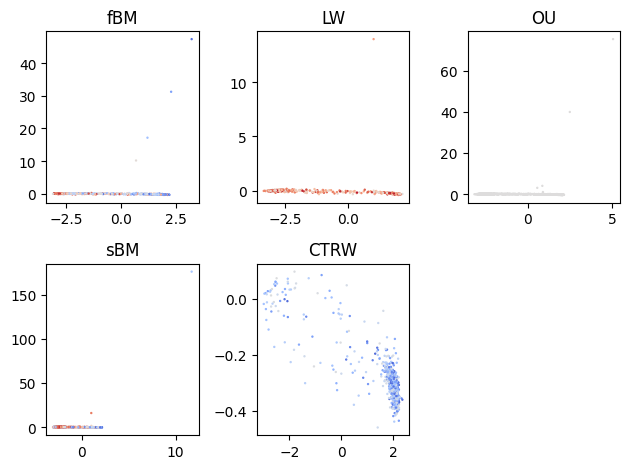

In [9]:
fig = plt.figure()
for m in np.unique(info["model"]):
    ax = fig.add_subplot(2,3,m+1)
    col = info["alpha"][info["model"] == m]
    if ds_params["RW_types"][m] == "OU":
        col = np.ones_like(h[info["model"] == m,0])
    ax.scatter(
        h[info["model"] == m,0],
        h[info["model"] == m,1],
        c=col,
        cmap="coolwarm",vmin=0,vmax=2,
        s=.5, label=ds_params["RW_types"][m])
    ax.set_title(ds_params["RW_types"][m])
plt.tight_layout()
#plt.xlim((-2,2))
#plt.ylim((-2,2))

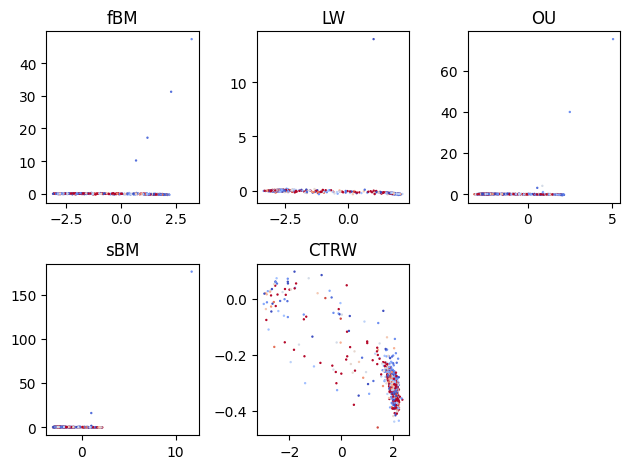

In [10]:
fig = plt.figure()
for m in np.unique(info["model"]):
    ax = fig.add_subplot(2,3,m+1)
    col = info["alpha"][info["model"] == m]
    if ds_params["RW_types"][m] == "OU":
        col = np.ones_like(h[info["model"] == m,0])
    ax.scatter(
        h[info["model"] == m,0],
        h[info["model"] == m,1],
        c=info["length"][info["model"] == m],
        cmap="coolwarm",vmin=7,vmax=20,
        s=.5, label=ds_params["RW_types"][m])
    ax.set_title(ds_params["RW_types"][m])
plt.tight_layout()
#plt.xlim((-2,2))
#plt.ylim((-2,2))

In [11]:
dl = dm.train_dataloader()
for batch in dl:
    break

(array([ 2.,  8.,  2.,  4.,  6.,  6.,  7., 14.,  6.,  7.,  9., 10., 12.,
         3., 11., 10., 10., 12.,  5.,  9.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        , 1.10000002, 1.20000005, 1.29999995, 1.39999998,
        1.5       , 1.60000002, 1.70000005, 1.79999995, 1.89999998,
        2.        ]),
 <BarContainer object of 20 artists>)

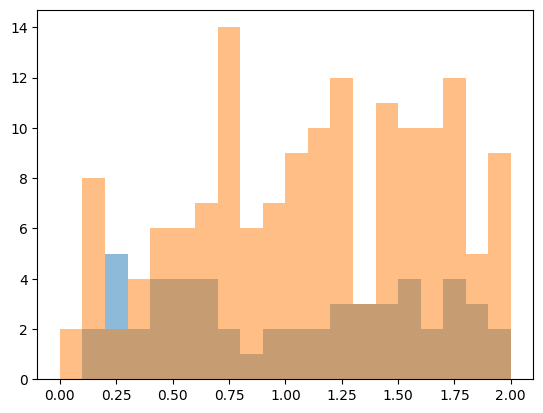

In [12]:
cond_alpha = model.cond_generators["diff"](batch)
plt.hist(batch.alpha[cond_alpha,0],bins=20,range=(0,2),alpha=.5)
plt.hist(batch.alpha[~cond_alpha,0],bins=20,range=(0,2),alpha=.5)

(array([ 2., 10.,  7.,  6., 10., 10., 11., 14.,  0.,  0.,  0.,  0.,  0.,
         0., 14., 14., 12., 16.,  8., 11.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        , 1.10000002, 1.20000005, 1.29999995, 1.39999998,
        1.5       , 1.60000002, 1.70000005, 1.79999995, 1.89999998,
        2.        ]),
 <BarContainer object of 20 artists>)

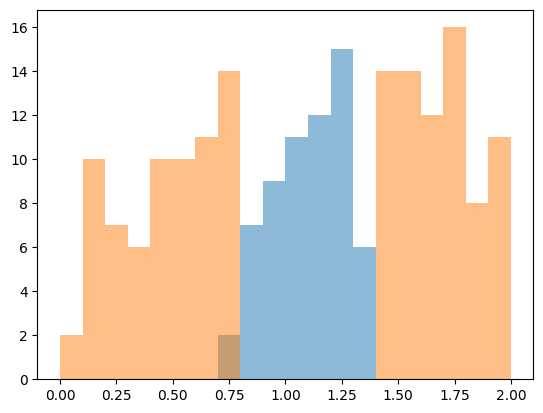

In [13]:
cond_alpha = model.cond_generators["alpha"](batch)
plt.hist(batch.alpha[cond_alpha,0],bins=20,range=(0,2),alpha=.5)
plt.hist(batch.alpha[~cond_alpha,0],bins=20,range=(0,2),alpha=.5)

In [14]:
comps = np.zeros((5,5))
for _ in range(5000):
    conds = model.cond_generators["model"](batch)

    for k in range(len(conds) // 2):
        i,j = torch.unique(batch.model[conds[2*k]]), torch.unique(batch.model[conds[2*k+1]])
        comps[i,j] += 1

([<matplotlib.axis.XTick at 0x7f5c637fce50>,
 [Text(0, 0, 'fBM'),
  Text(1, 0, 'LW'),
  Text(2, 0, 'OU'),
  Text(3, 0, 'sBM'),
  Text(4, 0, 'CTRW')])

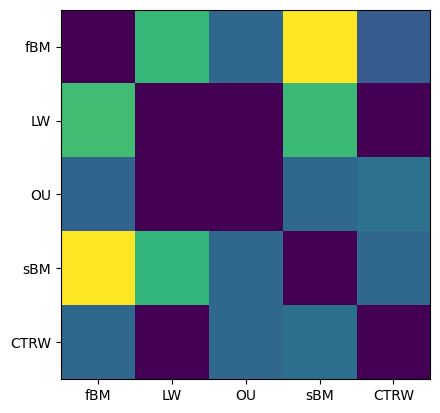

In [15]:
plt.imshow(comps)
plt.yticks(np.arange(5),ds_params["RW_types"])
plt.xticks(np.arange(5),ds_params["RW_types"])

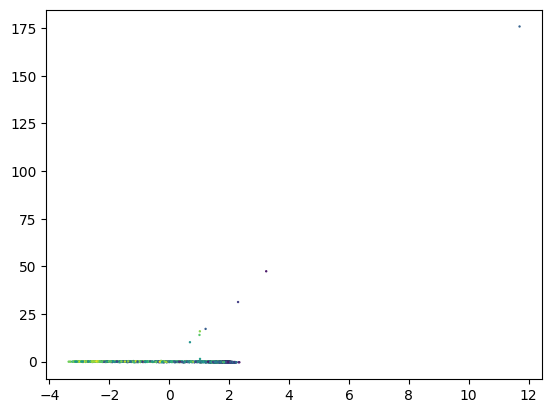

In [16]:
plt.scatter(h[:,0],h[:,1],c=info["alpha"],s=.5)
#plt.xlim((-2,2))
#plt.ylim((-2,2))

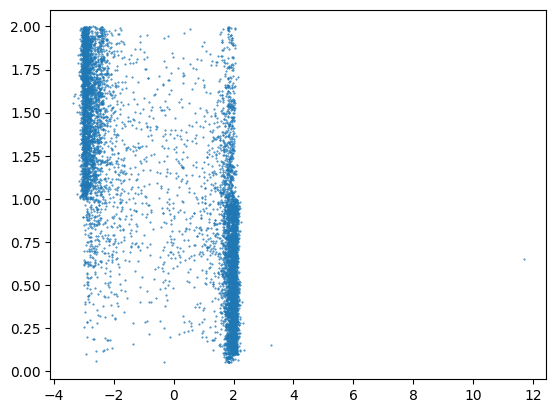

In [17]:
plt.scatter(h[:,0],info["alpha"],s=.2)

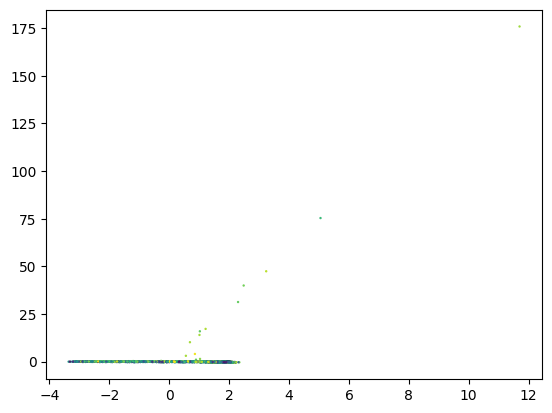

In [18]:
plt.scatter(h[:,0],h[:,1],c=info["log_diffusion"],s=.5)

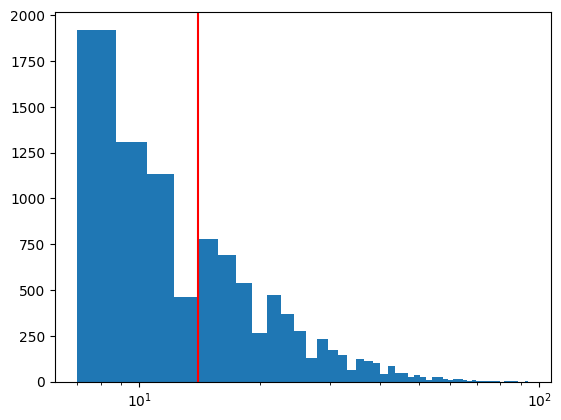

In [19]:
plt.hist(info["length"],bins=50);
plt.xscale("log")
plt.axvline(np.median(info["length"]),c="red");

(array([ 464.,  732.,  952., 1339., 1430., 1389., 1226., 1012.,  768.,
         456.]),
 array([-2.49913311, -2.19936037, -1.89958787, -1.59981525, -1.30004251,
        -1.00026989, -0.70049727, -0.40072465, -0.10095201,  0.19882064,
         0.49859327]),
 <BarContainer object of 10 artists>)

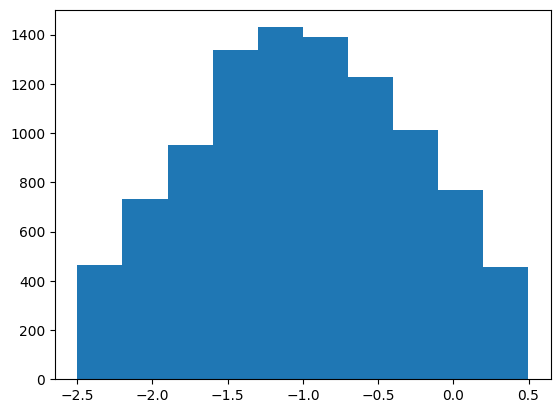

In [20]:
plt.hist(info["log_diffusion"])